In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
from scipy import ndimage
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap

In [2]:
path = '/vol/aibn1081/data1/brodriguez/'

In [3]:
from astropy.cosmology import LambdaCDM#, FlatLambdaCDM
cosmo = LambdaCDM(H0=69.7,Om0=0.3,Ode0=0.7)

In [4]:
#inclination = 53
#PA = 12
z = 0.02405
D_lum = cosmo.luminosity_distance(z)
D_ang = cosmo.angular_diameter_distance(z)
print('Luminsoty distance at z =',z,f': {D_lum:.6}')
print('Angular diameter distance at z =',z,f': {D_ang:.6}')

Luminsoty distance at z = 0.02405 : 105.355 Mpc
Angular diameter distance at z = 0.02405 : 100.465 Mpc


In [9]:
CO_cube = SpectralCube.read(path+'UGC12250_7m_co21_pbcor.fits')
CO_cube = CO_cube.minimal_subcube()
if CO_cube.unit == 'Jy/beam':
    CO_cube = CO_cube.to(u.K)
if CO_cube.header['CUNIT3'] == 'm/s':
    CO_cube = CO_cube.with_spectral_unit(u.km/u.s)

In [91]:
#WCS(hdu_list[0].header).celestial
pix_scale_aca = (CO_cube.header['CDELT2']*u.deg).to(u.arcsec).value # spaxel size in arcsec
pix_area_aca = ((pix_scale_aca*D_ang/206265)**2).to(u.kpc**2)
print(f'Angular size of ACA spaxel: {pix_scale_aca:.2} arcsec')
print(f'Surface area per ACA spaxel: {pix_area_aca:.6}')

Angular size of ACA spaxel: 1.5 arcsec
Surface area per ACA spaxel: 0.533775 kpc2


In [5]:
hdu_list = fits.open(path+'UGC12250.Pipe3D.cube.fits')
hdu_list.info()

Filename: /vol/aibn1081/data1/brodriguez/UGC12250.Pipe3D.cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ORG_HDR       1 PrimaryHDU     515   ()      
  1  SSP           1 ImageHDU       118   (160, 149, 21)   float64   
  2  SFH           1 ImageHDU      1608   (160, 149, 319)   float64   
  3  INDICES       1 ImageHDU        79   (160, 149, 70)   float64   
  4  ELINES        1 ImageHDU        68   (160, 149, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1310   (160, 149, 432)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      3134   (160, 149, 1040)   float64   
  7  GAIA_MASK     1 ImageHDU        10   (160, 149)   float64   
  8  SELECT_REG    1 ImageHDU        10   (160, 149)   int64   


In [92]:
#WCS(hdu_list[0].header).celestial
pix_scale_califa = (hdu_list[0].header['CDELT2']*u.deg).to(u.arcsec).value # spaxel size in arcsec
pix_area_califa = ((pix_scale_califa*D_ang/206265)**2).to(u.kpc**2)
print(f'Angular size of CALIFA pixel: {pix_scale_califa:.2} arcsec')
print(f'Surface area per CALIFA pixel: {pix_area_califa:.6}')

Angular size of CALIFA pixel: 0.5 arcsec
Surface area per CALIFA pixel: 0.0593083 kpc2


In [17]:
gaia = hdu_list[7].data
region = hdu_list[8].data

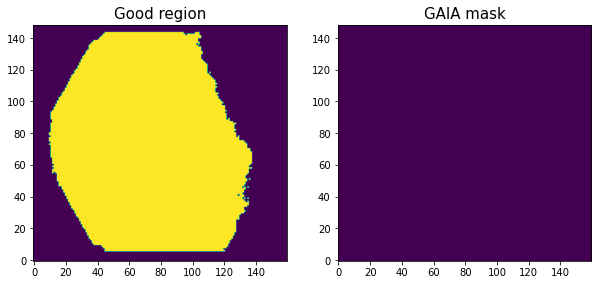

In [9]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(region,origin='lower')
axs[0].set_title('Good region',size=15)
axs[1].imshow(gaia,origin='lower')
axs[1].set_title('GAIA mask',size=15)
plt.show()

In [20]:
ssp = hdu_list[1].data

In [3]:
# check header for PIPE3D output indices
#hdu_list[1].header

In [4]:
# check header for emission line flux and flux error indices
#hdu_list[5].header

In [9]:
#lines = [hdu_list[5].data[i] for i in [26,28,41,45,46,49,207,242,244,257,261,262,265,423]]
#lines = np.array(lines)
#frames[6] = -frames[6] # Ha emission line has negative EW, this makes it positive
# flux_OIII5007 -> 0, eflux_OIII5007 -> 7
# flux_Hbeta    -> 1, eflux_Hbeta    -> 8
# flux_OI6300   -> 2, eflux_OI6300   -> 9
# flux_Halpha   -> 3, eflux_Halpha   -> 10
# flux_NII6584  -> 4, eflux_NII6584  -> 11
# flux_SII6717  -> 5, eflux_SII6717  -> 12
# EW_Halpha     -> 6, eEW_Halpha     -> 13

In [93]:
# fluxes in 10^-16 erg s^-1 cm^-2
F_NII = hdu_list[5].data[46]
F_OIII = hdu_list[5].data[26]
F_Ha = hdu_list[5].data[45]
F_Hb = hdu_list[5].data[28]
# EW in Angstrom
EW_Ha = -hdu_list[5].data[207]
EW_Ha_err = hdu_list[5].data[423]

In [49]:
# masking according to Ha_EW>6A and Ha_EW S/N>1
Ha_mask = (EW_Ha/EW_Ha_err>1)&(EW_Ha>6)

In [94]:
for i in range(len(ssp)):
    ssp[i][region<1] = np.nan
for frame in [F_Ha,F_Hb,F_OIII,F_NII,EW_Ha,EW_Ha_err]:
    frame[region<1] = np.nan

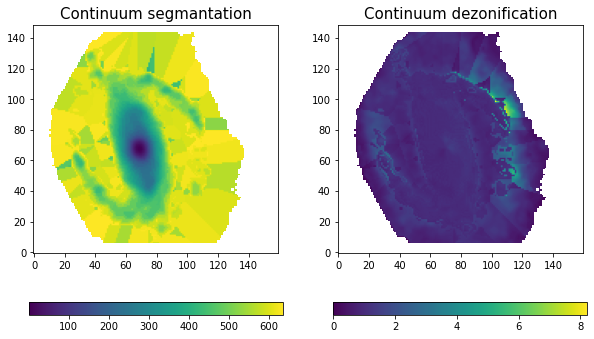

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,label in zip(axs.ravel(),[ssp[1],ssp[2]],['segmantation','dezonification']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal')
    ax.set_title('Continuum '+label,size=15)
plt.show()

In [ ]:
theta_min = 5.4
theta_maj = 9.4
pa_beam = -36

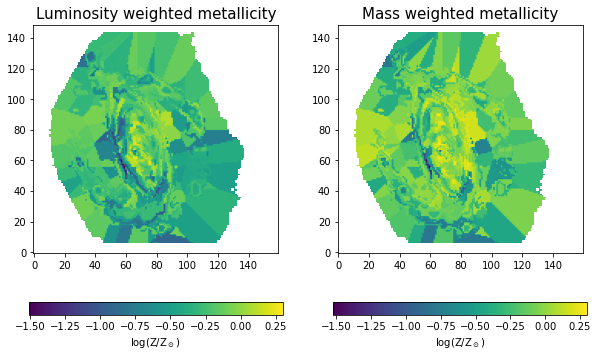

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,label in zip(axs.ravel(),[ssp[8],ssp[9]],['Luminosity','Mass']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log(Z/Z$_\odot$)')
    ax.set_title(label+' weighted metallicity',size=15)
plt.show()

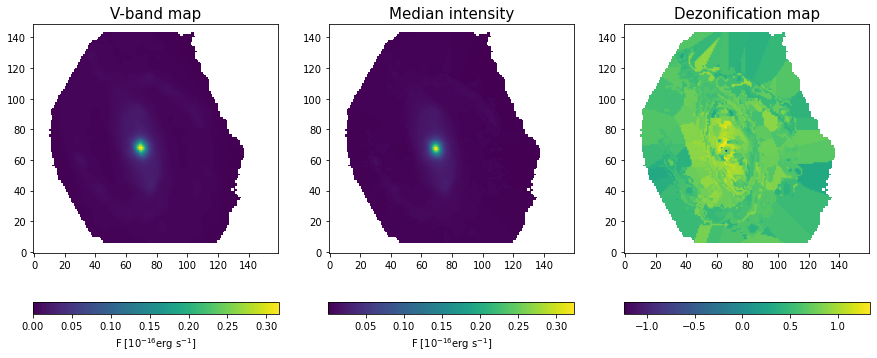

In [155]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,title,label in zip(axs.ravel(),[ssp[0],ssp[3],ssp[17]],
                          ['V-band map','Median intensity','Dezonification map'],[r'F [10$^{-16}$erg s$^{-1}$]',r'F [10$^{-16}$erg s$^{-1}$]','']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
plt.show()

/tmp/ipykernel_2218422/1647933733.py:2: RuntimeWarning: divide by zero encountered in log10
  for ax,frame,label in zip(axs.ravel(),[ssp[18],ssp[19],ssp[19]+np.log10(ssp[2])],['',' (dust-corrected)',' (dezonification-corrected)']):


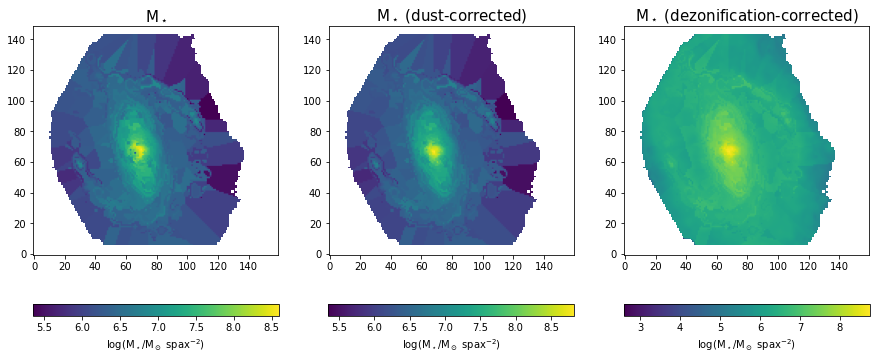

In [154]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,label in zip(axs.ravel(),[ssp[18],ssp[19],ssp[19]+np.log10(ssp[2])],['',' (dust-corrected)',' (dezonification-corrected)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log(M$_\star$/M$_\odot$ spax$^{-2}$)')
    ax.set_title(r'M$_\star$'+label,size=15)
plt.show()

In [96]:
M_star = np.power(10,ssp[19])*ssp[2]

In [100]:
M_star_tot = np.nansum(M_star)
print(rf'Total stellar mass: {M_star_tot:.4} solar masses')
F_NII_tot = np.nansum(F_NII)
print(f'Total NII flux: {F_NII_tot:.4} 10^-16 erg s^1')
F_OIII_tot = np.nansum(F_OIII)
print(f'Total OIII flux: {F_OIII_tot:.4} 10^-16 erg s^1')
F_Ha_tot = np.nansum(F_Ha)
print(f'Total Ha flux: {F_Ha_tot:.4} 10^-16 erg s^1')
F_Hb_tot = np.nansum(F_Hb)
print(f'Total Hb flux: {F_Hb_tot:.4} 10^-16 erg s^1')

Total stellar mass: 7.352e+10 solar masses
Total NII flux: 360.0 10^-16 erg s^1
Total OIII flux: 109.2 10^-16 erg s^1
Total Ha flux: 863.1 10^-16 erg s^1
Total Hb flux: 271.1 10^-16 erg s^1


/tmp/ipykernel_2218422/2550215394.py:2: RuntimeWarning: divide by zero encountered in log10
  for ax,frame,label in zip(axs.ravel(),[ssp[18],ssp[19],ssp[19]+np.log10(ssp[2])],['',' (dust-corrected)',' (dezonification-corrected)']):


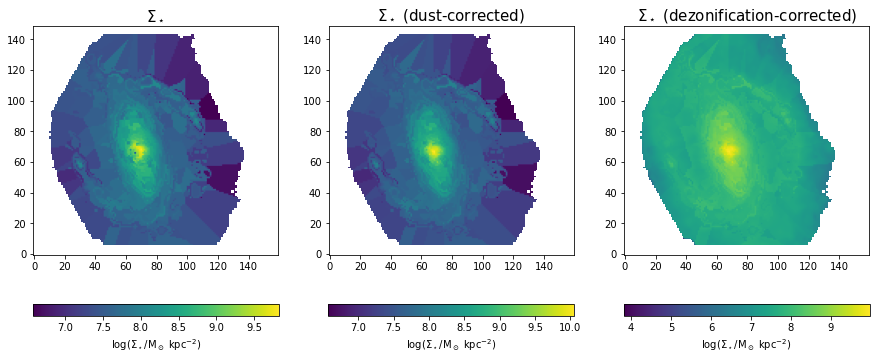

In [109]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,label in zip(axs.ravel(),[ssp[18],ssp[19],ssp[19]+np.log10(ssp[2])],['',' (dust-corrected)',' (dezonification-corrected)']):
    im = ax.imshow(frame-np.log10(pix_area.value),origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log($\Sigma_\star$/M$_\odot$ kpc$^{-2}$)')
    ax.set_title(r'$\Sigma_\star$'+label,size=15)
plt.show()

In [111]:
np.log10(np.nansum(np.power(10,ssp[19])*ssp[2]))

10.866415228235187

In [102]:
(2*10**20/u.cm**2).to(1/u.pc**2)*2/(6.02*10**23)

<Quantity 6.32651571e+33 1 / pc2>

In [105]:
# molecular Hydrogen column density to mass surface density
# X_co 2*10^20/(cm^2 K km s^-1)
# alpha_co = 4.3 M_sun/(pc^2 K km s^-1)
(2*10**20/u.cm**2).to(1/u.pc**2)*2.016*(1.66*10**-27)/(1.988*10**30)

<Quantity 3.20562947 1 / pc2>

In [24]:
Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
Ha_to_Hb = np.where(np.isfinite(F_Ha),Ha_to_Hb,np.nan)

In [26]:
# from Villanueva et al. 2023
A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
A_Ha_mean = np.nanmean(A_Ha[A_Ha>0])
A_Ha = np.where(np.isnan(F_Hb)&~np.isnan(F_Ha),A_Ha_mean,A_Ha)

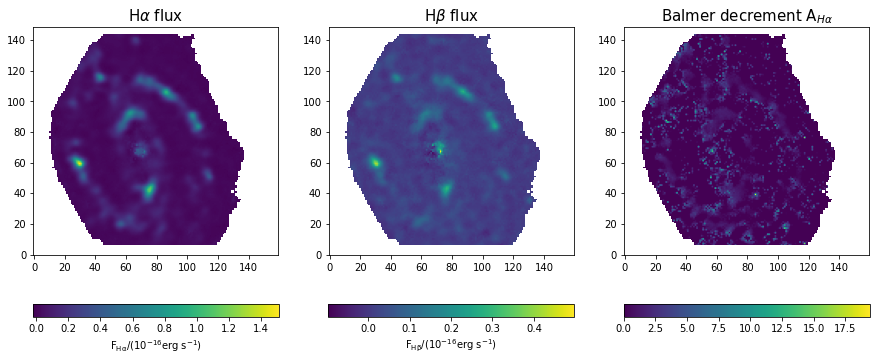

In [28]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,title,label in zip(axs.ravel(),[F_Ha,F_Hb,A_Ha],
                          [r'H$\alpha$ flux',r'H$\beta$ flux',r'Balmer decrement A$_{H\alpha}$'],[r'F$_\mathrm{H\alpha}/(10^{-16}$erg s$^{-1}$)',r'F$_\mathrm{H\beta}/(10^{-16}$erg s$^{-1}$)','']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
plt.show()

/tmp/ipykernel_2357433/2488321958.py:2: RuntimeWarning: invalid value encountered in log10
  for ax,frame,label in zip(axs.ravel(),[np.log10(F_Ha/F_Hb),np.log10(Ha_to_Hb),A_Ha],[r'H$\alpha$/H$\beta$',r'H$\alpha$/H$\beta$',r'Balmer decrement A$_{H\alpha}$']):


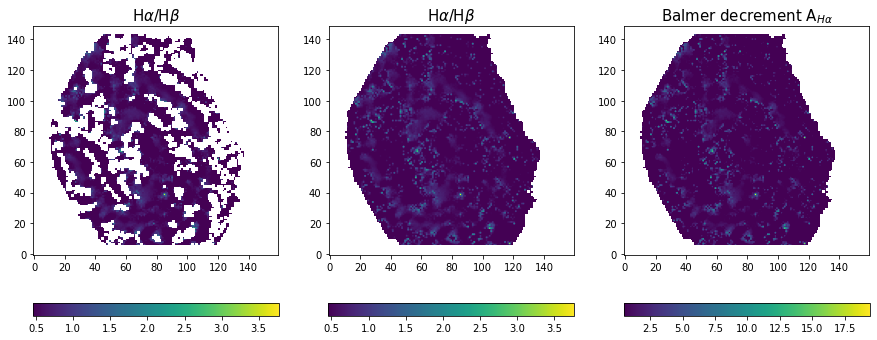

In [31]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,label in zip(axs.ravel(),[np.log10(F_Ha/F_Hb),np.log10(Ha_to_Hb),A_Ha],[r'H$\alpha$/H$\beta$',r'H$\alpha$/H$\beta$',r'Balmer decrement A$_{H\alpha}$']):
    im = ax.imshow(frame,origin='lower',vmin=0.4564)
    fig.colorbar(im,ax=ax,orientation='horizontal')
    ax.set_title(label,size=15)
plt.show()

In [57]:
#logZ_sun = np.log10(4.9*10**-4) # solar metallicuty, Baumgartner & Mushotzky 2006
# from Bolatto et al. 2017 and Marino et al. 2013
#O3N2 = np.log10(F_OIII*F_Ha/(F_Hb*F_NII))
#N2 = np.log10(F_NII/F_Ha)
#logZ_O3N2 = -12 + 8.533 - 0.214*O3N2
#logZ_N2 = -12 + 8.743 - 0.462*N2

/tmp/ipykernel_2218422/2286619392.py:2: RuntimeWarning: invalid value encountered in log10
  O3N2 = np.log10(F_OIII*F_Ha/(F_Hb*F_NII))
/tmp/ipykernel_2218422/2286619392.py:3: RuntimeWarning: invalid value encountered in log10
  N2 = np.log10(F_NII/F_Ha)


In [32]:
Z_sun = 4.9*10**-4 # solar metallicuty, Baumgartner & Mushotzky 2006
# from Bolatto et al. 2017 and Marino et al. 2013
O3N2 = np.log10(F_OIII*F_Ha/(F_Hb*F_NII))
N2 = np.log10(F_NII/F_Ha)
Z_O3N2 = np.power(10,-12 + 8.533 - 0.214*O3N2)/Z_sun
Z_N2 = np.power(10,-12 + 8.743 - 0.462*N2)/Z_sun

/tmp/ipykernel_2357433/4292659288.py:3: RuntimeWarning: invalid value encountered in log10
  O3N2 = np.log10(F_OIII*F_Ha/(F_Hb*F_NII))
/tmp/ipykernel_2357433/4292659288.py:4: RuntimeWarning: invalid value encountered in log10
  N2 = np.log10(F_NII/F_Ha)


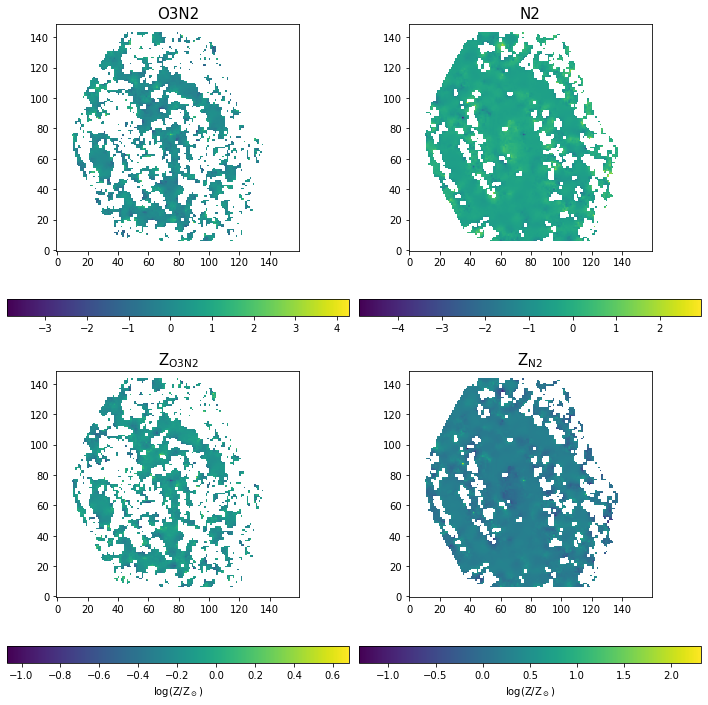

In [33]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
for ax,frame,title,label in zip(axs.ravel(),[O3N2,N2,np.log10(Z_O3N2),np.log10(Z_N2)],
                          [r'O3N2',r'N2',r'Z$_\mathrm{O3N2}$','Z$_\mathrm{N2}$'],['','',r'log(Z/Z$_\odot$)',r'log(Z/Z$_\odot$)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
fig.tight_layout()
plt.show()

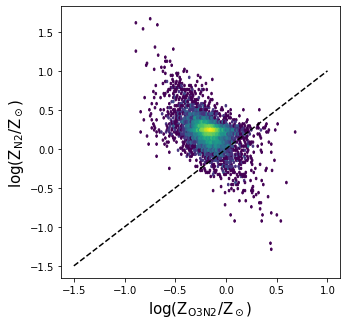

In [36]:
fig, ax = plt.subplots(figsize=(5,5))
ax.hexbin(np.log10(Z_O3N2).flatten(),np.log10(Z_N2).flatten(),bins='log')
ax.plot([-1.5,1.],[-1.5,1.],c='k',ls='--')
ax.set_xlabel(r'log(Z$_\mathrm{O3N2}$/Z$_\odot$)',size=15)
ax.set_ylabel(r'log(Z$_\mathrm{N2}$/Z$_\odot$)',size=15)
plt.show()

In [37]:
# from Villanueva et al. 2023, Rosa-Gonzalez 2002
SFR = 1.61*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*(D_lum**2).to(u.cm**2).value
# 10^-16 factor converts fluxes to erg s^-1
# 1.61 factor corrects from Salpeter IMF to Kroupa IMF

/tmp/ipykernel_2357433/1809114548.py:2: RuntimeWarning: invalid value encountered in log10
  for ax,frame,title,label in zip(axs.ravel(),[np.log10(SFR),np.log10(SFR/pix_area_califa.value)],


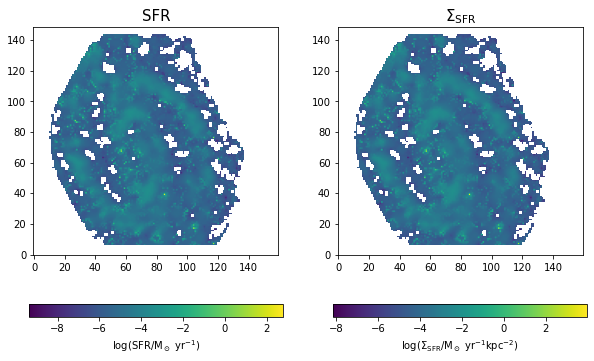

In [39]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,title,label in zip(axs.ravel(),[np.log10(SFR),np.log10(SFR/pix_area_califa.value)],
                          ['SFR','$\Sigma_\mathrm{SFR}$'],[r'log(SFR/M$_\odot$ yr$^{-1}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$ yr$^{-1} $kpc$^{-2}$)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
#im = ax.imshow(,origin='lower')
#fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log($\Sigma_\star$/M$_\odot$ yr$^{-1} $spax$^{-2}$)')
#ax.set_title(r'SFR',size=15)
plt.show()

In [40]:
S_GMC = 1
S_star = M_star/pix_area_califa.to(u.pc**2).value
alphaCO_O3N2 = 2.9*np.exp(0.4/(S_GMC*Z_O3N2))*np.power(S_star/100,np.where(S_star>100,0.5,0))
alphaCO_N2 = 2.9*np.exp(0.4/(S_GMC*Z_N2))*np.power(S_star/100,np.where(S_star>100,0.5,0))

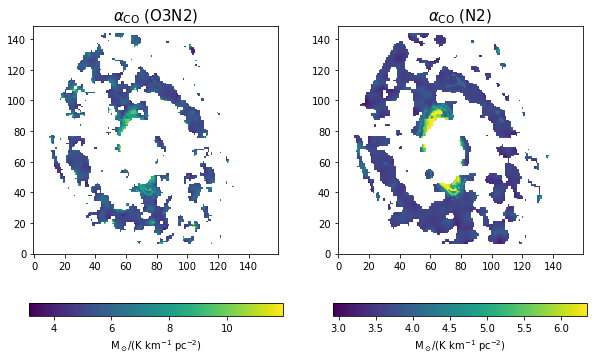

In [48]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,title,label in zip(axs.ravel(),[alphaCO_O3N2,alphaCO_N2],
                          [r'$\alpha_\mathrm{CO}$ (O3N2)',r'$\alpha_\mathrm{CO}$ (N2)'],[r'M$_\odot$/(K km$^{-1}$ pc$^{-2}$)',r'M$_\odot$/(K km$^{-1}$ pc$^{-2}$)']):
    data = np.where(region&(EW_Ha>6),frame,np.nan)
    im = ax.imshow(data,origin='lower',vmax=np.nanpercentile(data,99))
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
plt.show()

In [101]:
califa_hdr = WCS(hdu_list[0].header).to_header()
califa_hdr['CRPIX3']=0
califa_hdr['CTYPE3']='VRAD'
califa_hdr['CUNIT3']='m/s'

In [102]:
mom0 = CO_cube.moment(order=0)
target_header = mom0.header

In [103]:
beam_califa = radio_beam.Beam(major=2.5*u.arcsec, minor=2.5*u.arcsec, pa=0*u.deg)
beam_CO = radio_beam.Beam(major=6*u.arcsec, minor=6*u.arcsec, pa=0*u.deg)

In [104]:
frames_cube = SpectralCube(data=np.array([M_star,F_NII,F_OIII,F_Ha,F_Hb]),wcs=WCS(califa_hdr))
frames_cube = frames_cube.with_mask(region)
#frames_cube = frames_cube.with_mask(Ha_mask)
frames_cube = frames_cube.with_beam(beam_califa)

In [105]:
frames_cube_convolved = frames_cube.convolve_to(beam_CO)

In [109]:
reprojected_list = []
for frame in frames_cube:#_convolved:
    reprojected, footprint = reproject_exact((frame,WCS(califa_hdr).celestial),target_header)
    reprojected_list.append(reprojected)
reprojected_list = np.array(reprojected_list)

In [110]:
[M_star_rep,F_NII_rep,F_OIII_rep,F_Ha_rep,F_Hb_rep] = reprojected_list

In [100]:
M_star_tot = np.nansum(M_star)
print(rf'Total stellar mass: {M_star_tot:.4} solar masses')
F_NII_tot = np.nansum(F_NII)
print(f'Total NII flux: {F_NII_tot:.4} 10^-16 erg s^1')
F_OIII_tot = np.nansum(F_OIII)
print(f'Total OIII flux: {F_OIII_tot:.4} 10^-16 erg s^1')
F_Ha_tot = np.nansum(F_Ha)
print(f'Total Ha flux: {F_Ha_tot:.4} 10^-16 erg s^1')
F_Hb_tot = np.nansum(F_Hb)
print(f'Total Hb flux: {F_Hb_tot:.4} 10^-16 erg s^1')

Total stellar mass: 7.352e+10 solar masses
Total NII flux: 360.0 10^-16 erg s^1
Total OIII flux: 109.2 10^-16 erg s^1
Total Ha flux: 863.1 10^-16 erg s^1
Total Hb flux: 271.1 10^-16 erg s^1


In [112]:
M_star_rep_tot = np.nansum(M_star_rep)
print(rf'Total stellar mass: {M_star_rep_tot:.4} solar masses')
F_NII_rep_tot = np.nansum(F_NII_rep)
print(f'Total NII flux: {F_NII_rep_tot:.4} 10^-16 erg s^1')
F_OIII_rep_tot = np.nansum(F_OIII_rep)
print(f'Total OIII flux: {F_OIII_rep_tot:.4} 10^-16 erg s^1')
F_Ha_rep_tot = np.nansum(F_Ha_rep)
print(f'Total Ha flux: {F_Ha_rep_tot:.4} 10^-16 erg s^1')
F_Hb_rep_tot = np.nansum(F_Hb_rep)
print(f'Total Hb flux: {F_Hb_rep_tot:.4} 10^-16 erg s^1')

Total stellar mass: 8.088e+09 solar masses
Total NII flux: 39.22 10^-16 erg s^1
Total OIII flux: 11.81 10^-16 erg s^1
Total Ha flux: 94.32 10^-16 erg s^1
Total Hb flux: 29.37 10^-16 erg s^1


In [108]:
M_star_rep_tot = np.nansum(M_star_rep)
print(rf'Total stellar mass: {M_star_rep_tot:.4} solar masses')
F_NII_rep_tot = np.nansum(F_NII_rep)
print(f'Total NII flux: {F_NII_rep_tot:.4} 10^-16 erg s^1')
F_OIII_rep_tot = np.nansum(F_OIII_rep)
print(f'Total OIII flux: {F_OIII_rep_tot:.4} 10^-16 erg s^1')
F_Ha_rep_tot = np.nansum(F_Ha_rep)
print(f'Total Ha flux: {F_Ha_rep_tot:.4} 10^-16 erg s^1')
F_Hb_rep_tot = np.nansum(F_Hb_rep)
print(f'Total Hb flux: {F_Hb_rep_tot:.4} 10^-16 erg s^1')

Total stellar mass: 8.075e+09 solar masses
Total NII flux: 39.16 10^-16 erg s^1
Total OIII flux: 11.82 10^-16 erg s^1
Total Ha flux: 94.07 10^-16 erg s^1
Total Hb flux: 29.32 10^-16 erg s^1


In [88]:
Ha_to_Hb_rep = np.where(F_Ha_rep/F_Hb_rep>2.86,F_Ha_rep/F_Hb_rep,2.86) # imposing minimum ratio of 2.86
Ha_to_Hb_rep = np.where(np.isfinite(F_Ha_rep),Ha_to_Hb_rep,np.nan)

In [89]:
# from Villanueva et al. 2023
A_Ha_rep = 5.86*np.log10(Ha_to_Hb_rep/2.86)
A_Ha_mean_rep = np.nanmean(A_Ha_rep[A_Ha_rep>0])
A_Ha_rep = np.where(np.isnan(F_Hb_rep)&~np.isnan(F_Ha_rep),A_Ha_mean_rep,A_Ha_rep)

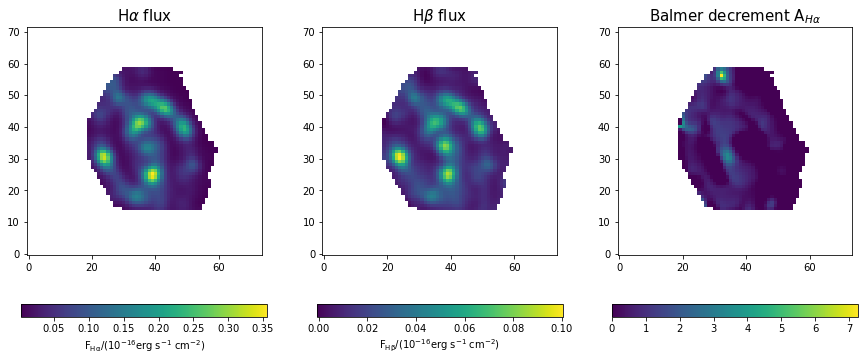

In [90]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,title,label in zip(axs.ravel(),[F_Ha_rep,F_Hb_rep,A_Ha_rep],
                          [r'H$\alpha$ flux',r'H$\beta$ flux',r'Balmer decrement A$_{H\alpha}$'],[r'F$_\mathrm{H\alpha}/(10^{-16}$erg s$^{-1}$ cm$^{-2}$)',r'F$_\mathrm{H\beta}/(10^{-16}$erg s$^{-1}$ cm$^{-2}$)','']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
plt.show()

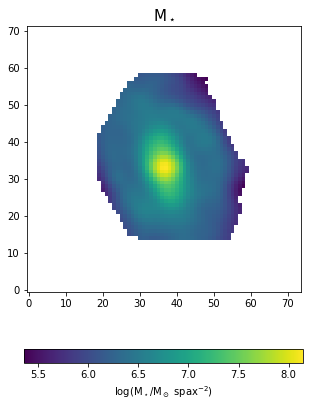

In [71]:
fig, ax = plt.subplots(figsize=(5,7))
im = ax.imshow(np.log10(M_star),origin='lower')
fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log(M$_\star$/M$_\odot$ spax$^{-2}$)')
ax.set_title(r'M$_\star$'+label,size=15)
plt.show()

In [72]:
np.log10(np.nansum(M_star))

9.907168578365178

In [111]:
np.log10(np.nansum(np.power(10,ssp[19])*ssp[2]))

10.866415228235187

In [ ]:
Z_sun = 4.9*10**-4 # solar metallicuty, Baumgartner & Mushotzky 2006
# from Bolatto et al. 2017 and Marino et al. 2013
O3N2 = np.log10(F_OIII*F_Ha/(F_Hb*F_NII))
N2 = np.log10(F_NII/F_Ha)
Z_O3N2 = np.power(10,-12 + 8.533 - 0.214*O3N2)/Z_sun
Z_N2 = np.power(10,-12 + 8.743 - 0.462*N2)/Z_sun

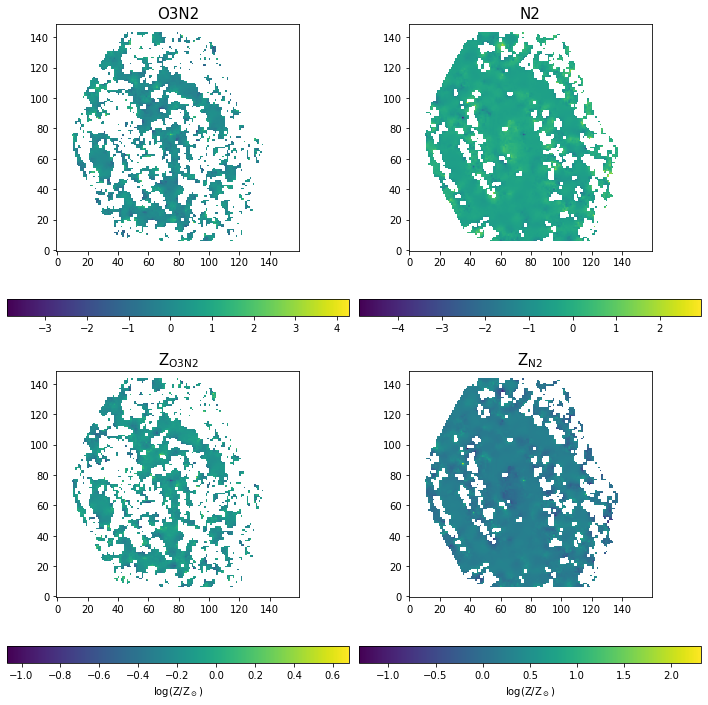

In [33]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
for ax,frame,title,label in zip(axs.ravel(),[O3N2,N2,np.log10(Z_O3N2),np.log10(Z_N2)],
                          [r'O3N2',r'N2',r'Z$_\mathrm{O3N2}$','Z$_\mathrm{N2}$'],['','',r'log(Z/Z$_\odot$)',r'log(Z/Z$_\odot$)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
fig.tight_layout()
plt.show()

In [73]:
# from Villanueva et al. 2023, Rosa-Gonzalez 2002
SFR = 1.61*7.9*(10**-(42+16))*F_Ha*np.power(10,A_Ha/2.5)*(D_lum**2).to(u.cm**2).value
# 10^-16 factor converts fluxes to erg s^-1
# 1.61 factor corrects from Salpeter IMF to Kroupa IMF

/tmp/ipykernel_2357433/1809114548.py:2: RuntimeWarning: invalid value encountered in log10
  for ax,frame,title,label in zip(axs.ravel(),[np.log10(SFR),np.log10(SFR/pix_area_califa.value)],


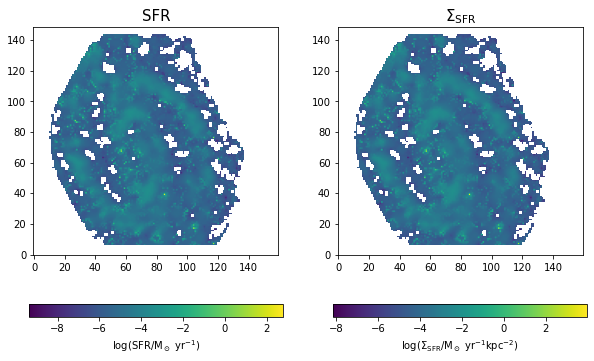

In [39]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,title,label in zip(axs.ravel(),[np.log10(SFR),np.log10(SFR/pix_area_aca.value)],
                          ['SFR','$\Sigma_\mathrm{SFR}$'],[r'log(SFR/M$_\odot$ yr$^{-1}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$ yr$^{-1} $kpc$^{-2}$)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
#im = ax.imshow(,origin='lower')
#fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log($\Sigma_\star$/M$_\odot$ yr$^{-1} $spax$^{-2}$)')
#ax.set_title(r'SFR',size=15)
plt.show()

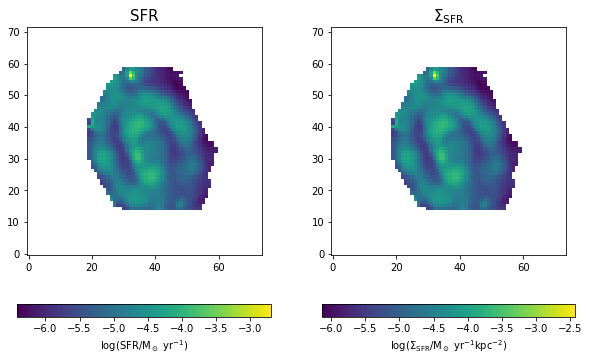

In [74]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,title,label in zip(axs.ravel(),[np.log10(SFR),np.log10(SFR/pix_area_aca.value)],
                          ['SFR','$\Sigma_\mathrm{SFR}$'],[r'log(SFR/M$_\odot$ yr$^{-1}$)',r'log($\Sigma_\mathrm{SFR}$/M$_\odot$ yr$^{-1} $kpc$^{-2}$)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
#im = ax.imshow(,origin='lower')
#fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log($\Sigma_\star$/M$_\odot$ yr$^{-1} $spax$^{-2}$)')
#ax.set_title(r'SFR',size=15)
plt.show()